### MODEL 2 : Building a Convolutional Neural Network (CNN)
CNN's are also known as ConvNets.

They are known for their ability to find patterns in visual data

In [1]:
import torch 
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt 
from tqdm import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


In [2]:
train_data=datasets.FashionMNIST(
    root="data", #where to download data to
    train=True,
    download=True,
    transform=ToTensor(), #How do we want to transform the data ?
    target_transform=None  #How do we want to transform the labels/targets ?
)

test_data=datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
len(train_data),len(test_data)

(60000, 10000)

In [3]:
image,label=train_data[0]
class_names=train_data.classes
class_to_idx = train_data.class_to_idx


In [4]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

#Turn datasets into iterables ( batches )
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x21e8a7972b0>,
 <torch.utils.data.dataloader.DataLoader at 0x21ef9a00460>)

In [5]:
torch.manual_seed(42)

class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates TinyVGG
    model from CNN explainer site.
    
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), #hyperparameters of Conv2d
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#kernel size can also be a tuple such as (2,2)

        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier_layer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)#out features -> class_names
        )

    def forward(self,x:torch.tensor):
        x=self.conv_block_1(x)
        #print(f"Output shape after conv block 1: {x.shape}")
        x=self.conv_block_2(x)
        #print(f"Output shape after conv block 2: {x.shape}")
        x=self.classifier_layer(x)
        #print(f"Output shape after classifier layer: {x.shape}")
        return x

In [6]:
def eval_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
    """ Returns a dictionary containing the results of model predicting on data_loader"""
    loss,acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            X,y=X.to(device),y.to(device)
            #make preds
            y_pred=model(X)

            #Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
        # Scale loss and acc to find the avarage loss/ acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,#only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [7]:
from helper_functions import accuracy_fn
def train_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device=device):
    """Performs a training with model trying to learn on data_loader."""
    train_loss,train_acc=0,0
    
    #Put model into training mode
    model.train()

    # Add a loop to loop through training batches X-> image, y->label(target)
    for batch , (X,y) in enumerate(data_loader):
        
        #Put data on target device
        X,y=X.to(device),y.to(device)
        
        #1. Forward pass (outputs the raw logits from the model)
        y_pred=model(X)

        #2. Calculate the loss
        loss=loss_fn(y_pred,y)
        train_loss +=loss #accumulate train loss
        train_acc+=accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1)) #go from logits->prediction labels
        
        #3. Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer
        optimizer.step() 

    train_loss/=len(data_loader)
    train_acc/=len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [8]:
def test_step(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn,
              device:torch.device=device):
    """Performs a testing loop step on model going over data_loader."""
    test_loss,test_acc=0,0

    #Put model into eval mode
    model.eval()

    with torch.inference_mode():
        for X,y in data_loader:
            #Data into device
            X,y=X.to(device),y.to(device)
            
            #1. Forward pass
            test_pred=model(X)

            #2. Calculate loss and acc(accumulatively)
            test_loss+=loss_fn(test_pred,y)
            test_acc+=accuracy_fn(y_true=y,
                                  y_pred=test_pred.argmax(dim=1))
            
        # Calculate the test loss/acc average per patch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"\nTest loss: {test_loss:.4f}, Test acc {test_acc:.4f}")

Image size: torch.Size([1, 28, 28])
Label: 2, label size: torch.Size([])


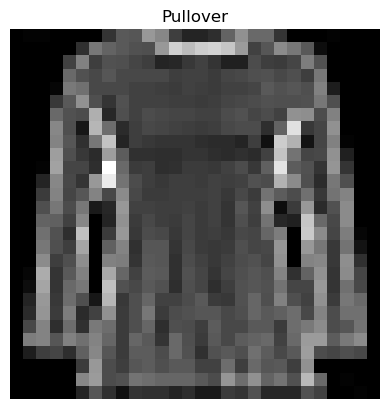

In [9]:
train_features_batch,train_labels_batch=next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape
random_idx=torch.randint(0,len(train_features_batch),size=[1]).item()
img,label=train_features_batch[random_idx],train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [10]:
torch.manual_seed(42)
#input shape is 1 beacuse we have 1 color channel
model_2=FashionMNISTModelV2(input_shape=1,
                            hidden_units=30,
                            output_shape=len(class_names)).to(device)

### Stepping through nn.Conv2d()

In [11]:
torch.manual_seed(42)

images=torch.randn(size=(32,3,64,64))
test_image=images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single images shape: {test_image.shape}")
print(f"Test image:\n {test_image}")


Image batch shape: torch.Size([32, 3, 64, 64])
Single images shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-

In [12]:
torch.manual_seed(42)
conv_layer=nn.Conv2d(in_channels=3,
                     out_channels=64,
                     kernel_size=3,
                     stride=1,
                     padding=1).to(device)

conv_output=conv_layer(test_image.unsqueeze(0).to(device))
conv_output.shape

torch.Size([1, 64, 64, 64])

In [13]:
#Print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

#Create a sample nn.MaxPool2d layer
max_pool_layer=nn.MaxPool2d(kernel_size=2)

#Pass data
test_image_through_conv=conv_layer(test_image.unsqueeze(dim=0).to(device))
print(f"Shape after conv layer: {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool=max_pool_layer(test_image_through_conv)
print(f"Shape after max pool : {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after conv layer: torch.Size([1, 64, 64, 64])
Shape after max pool : torch.Size([1, 64, 32, 32])


In [14]:
torch.manual_seed(42)

random_tensor=torch.randn(size=(1,1,2,2))
print(f"\nRandom tensor:\n{random_tensor}")
print(f"Random tensor shape:{random_tensor.shape}")

max_pool_layer=nn.MaxPool2d(kernel_size=2)

max_pool_tensor=max_pool_layer(random_tensor)

print(f"\nMax pool tensor:\n{max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")



Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape:torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [15]:
dummy_tensor=torch.randn(size=(1,28,28))
model_2(dummy_tensor.unsqueeze(dim=0).to(device))

tensor([[ 0.0361,  0.0298, -0.0393, -0.0253,  0.0455, -0.0426, -0.0075, -0.0253,
          0.0179, -0.0178]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
#Setup loss function eval metrics and optimizer
from helper_functions import accuracy_fn

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)


In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from helper_functions import print_train_time 

from timeit import default_timer as timer


train_time_start_model_2=timer()

epochs=3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n-------------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_2=timer()
total_train_time_model_2=print_train_time(start=train_time_start_model_2,
                                          end=train_time_end_model_2,
                                          device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
-------------
Train loss: 0.70642 | Train acc: 74.34%


 33%|███▎      | 1/3 [00:14<00:28, 14.41s/it]


Test loss: 0.3352, Test acc 88.1333
Epoch: 2
-------------
Train loss: 0.32571 | Train acc: 88.36%


 67%|██████▋   | 2/3 [00:29<00:14, 14.66s/it]


Test loss: 0.3243, Test acc 88.4133
Epoch: 3
-------------
Train loss: 0.28420 | Train acc: 89.78%


100%|██████████| 3/3 [00:43<00:00, 14.66s/it]


Test loss: 0.2526, Test acc 91.0550

Train time on cuda: 43.991 seconds


In [18]:
model_2_results=eval_model(model=model_2,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)
model_2_results

100%|██████████| 313/313 [00:01<00:00, 236.15it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2860717177391052,
 'model_acc': 89.63658146964856}

In [19]:
import pandas as pd 

#Previous models results
model_1_results={'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008368492126,
 'model_acc': 75.01996805111821}

model_0_results={'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4766390025615692,
 'model_acc': 83.42651757188499}

compare_results=pd.DataFrame([model_0_results,
                              model_1_results,
                              model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.286072,89.636581


In [20]:
#Previous models
total_train_time_model_0=22.325502400000005
total_train_time_model_1=25.00544179999997

compare_results["training time"]=[total_train_time_model_0,
                                  total_train_time_model_1,
                                  total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training time
0,FashionMNISTModelV0,0.476639,83.426518,22.325502
1,FashionMNISTModelV1,0.685001,75.019968,25.005442
2,FashionMNISTModelV2,0.286072,89.636581,43.990862


Text(0, 0.5, 'accuracy(%)')

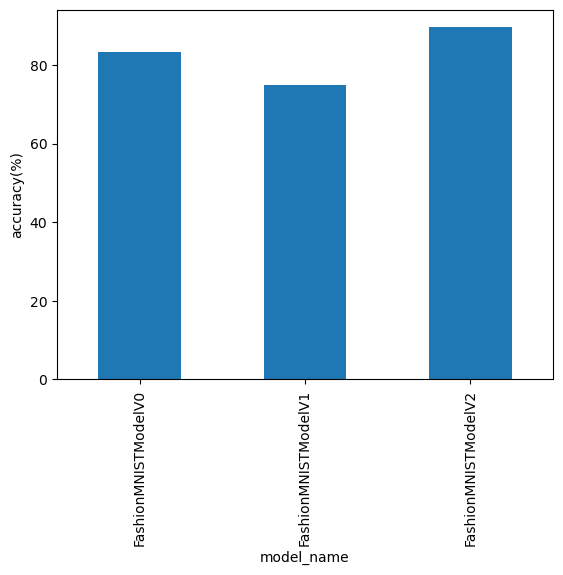

In [36]:
compare_results.set_index("model_name")["model_acc"].plot(kind="bar")
plt.ylabel("accuracy(%)")

### Make random predictions with our model

In [22]:
def make_predictions(model:torch.nn.Module,
                     data: list,
                     device:torch.device=device):
    pred_probs= []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            #Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample,dim=0).to(device)

            #Forward pass (model outputs raw logits)
            pred_logit=model(sample)

            #Get pred probs(logit to pred probs)
            pred_prob=torch.softmax(pred_logit.squeeze(),dim=0)

            #Turn pred probs in to prediction labels(targets)
            
            #Get pred_prob off the GPU for futher calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [29]:
import random
random.seed(42)

test_samples=[]
test_labels=[]

for sample, label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

#View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

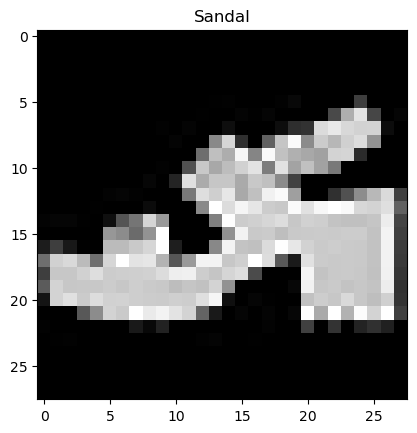

In [30]:
plt.imshow(test_samples[0].squeeze(dim=0),cmap="gray")
plt.title(class_names[test_labels[0]])

In [31]:
# Make predictions
pred_probs=make_predictions(model=model_2,
                            data=test_samples,
                            device=device)

#View first two prediction probabilities
pred_probs[:2]

tensor([[2.4178e-07, 1.6462e-08, 2.8470e-08, 2.7863e-08, 5.4616e-09, 9.9976e-01,
         7.3857e-07, 2.2043e-06, 9.1460e-06, 2.2559e-04],
        [2.3211e-02, 5.2021e-01, 5.9444e-04, 4.3655e-01, 6.3661e-03, 5.7848e-05,
         1.2660e-02, 1.5106e-04, 1.1887e-04, 7.3267e-05]])

In [32]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 6, 4, 7, 1])

In [33]:
# Are our predictions in the same form as our test labels? 
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 6, 4, 7, 1]))

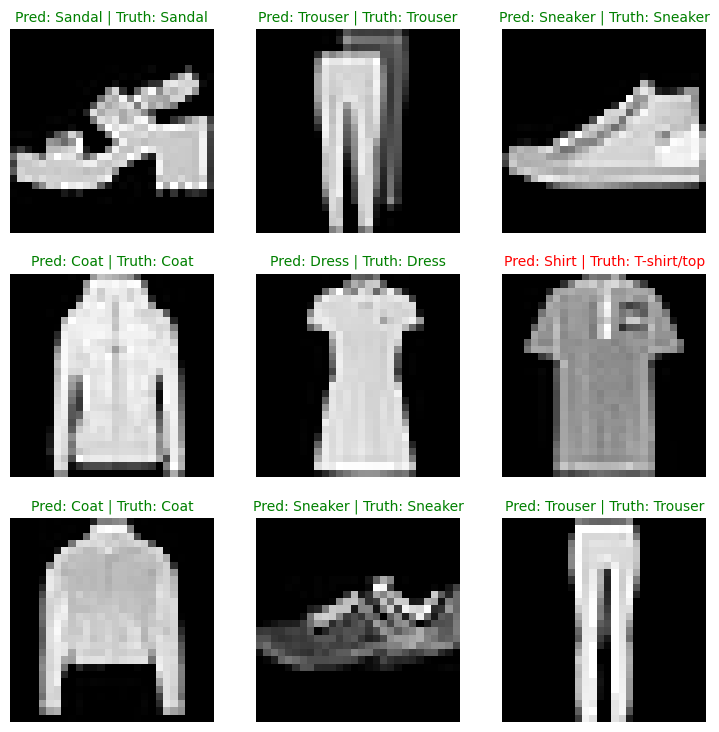

In [34]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="green") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="red") # red text if wrong
  plt.axis(False)

In [35]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2860717177391052,
 'model_acc': 89.63658146964856}